# Testing data pipeline

Get a dataloader based on given experiment config

In [1]:
from pathlib import Path

from hydra import initialize_config_dir, compose
from omegaconf import OmegaConf
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

from arithmetic_lm.dataset import DATASET_CLASSES
from arithmetic_lm.tokenizer import CharTokenizer

## Get config

In [12]:
EXPERIMENT = "15/exp15_trans_dec.yaml"
DATASET = "add_generalize_to_longer_19"
abs_config_dir = Path("..").resolve() / "arithmetic_lm/conf"

# add overrides if needed
overrides = [
    "training.only_answer_loss=true",
    "data.format.operand_random_spaces_amount=0.3",
]

if EXPERIMENT:
    overrides.append(f"+experiment={EXPERIMENT}")
if DATASET:
    overrides.append(f"data={DATASET}")
print(overrides)

with initialize_config_dir(version_base=None, config_dir=str(abs_config_dir)):
    cfg = compose(config_name="train.yaml", overrides=overrides)
    print(OmegaConf.to_yaml(cfg))

['training.only_answer_loss=true', 'data.format.operand_random_spaces_amount=0.3', '+experiment=15/exp15_trans_dec.yaml', 'data=add_generalize_to_longer_20']
data:
  train_ds_class: ArithmeticLMSequenceDataset
  format:
    pad: $
    pad_ops_zero: null
    pad_ans_zero: null
    reverse_ops: false
    reverse_ans: false
    encdec: false
    filler_tokens_prompt: 0
    filler_tokens_ans: 0
    operand_random_spaces_amount: 0.3
    chain_of_thought: false
  train: data/addition/exp_13/train_add_1-19_except18_1M.txt
  test:
    in_dist: data/addition/exp_13/test_add_in_distribution_2000.txt
    ood_18digit: data/addition/exp_13/test_add_ood_18digit_100.txt
    ood_20digit: data/addition/exp_13/test_add_ood_20digit_100.txt
model:
  name: TransformerDecoder
  args:
    context_len: 256
    n_embd: 768
    n_head: 4
    n_layers: 6
    dropout: 0.1
    pos_enc: abs
    pos_enc_max_shift: 0
    emb_type: learned
tokenizer:
  name: CharTokenizer
  args: {}
sampling:
  temp: 1.0
  top_k: 1
tr

## Initialize dataset and dataloader

In [13]:
tokenizer = CharTokenizer()

# dataset
ds_kwargs = {
    "tokenizer": tokenizer,
    "seq_len": cfg.model.args.context_len,
    "pad": cfg.data.format.pad,
    "pad_ops_zero": cfg.data.format.pad_ops_zero,
    "pad_ans_zero": cfg.data.format.pad_ans_zero,
    "reverse_ops": cfg.data.format.reverse_ops,
    "reverse_ans": cfg.data.format.reverse_ans,
    "filler_tokens_prompt": cfg.data.format.filler_tokens_prompt,
    "filler_tokens_ans": cfg.data.format.filler_tokens_ans,
    "equal_in_prompt": not cfg.data.format.encdec,
    "chain_of_thought": cfg.data.format.get("chain_of_thought", False),
    "operand_random_spaces_amount": cfg.data.format.get(
        "operand_random_spaces_amount", 0
    ),
}
ds_class = DATASET_CLASSES[cfg.data.train_ds_class]
ds = ds_class(Path("..").resolve() / cfg.data.train, **ds_kwargs)
print(ds, len(ds), ds[0])

<arithmetic_lm.dataset.arithmetic_dataset.ArithmeticLMSequenceDataset object at 0x1565366c0> 896200 (tensor([65,  0, 72,  0, 80,  0]), tensor([ 0, 72,  0, 80,  0, 65]))


In [14]:
# dataloader
dl = torch.utils.data.DataLoader(
    ds, batch_size=4, shuffle=True, num_workers=0, collate_fn=ds.collate_fn
)

## Get a batch of data and do whatever

In [21]:
from arithmetic_lm.model.utils import answer_mask

for i, batch in enumerate(dl):
    tgt = batch[1]
    print(tgt.shape)
    # decode and print tgt before
    for t in tgt:
        print(repr(tokenizer.decode(t)))

    answer_masked_tgt = answer_mask(
        tgt,
        pad_token_id=tokenizer.pad_token_id,
        equal_token_id=tokenizer.encode("=")[0],
    )

    print("AFTER")

    # decode and print tgt after
    for t in answer_masked_tgt:
        print(repr(tokenizer.decode(t)))

    break

torch.Size([4, 64])
'906+83 8=1744$\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c'
'6712119818068134347+30395500 13 6421 01904 =9751669831710236251$'
'1378+8 776=10154$\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c'
'41626513 667 345165+90857356112009117=132483869779354282$\x0c\x0c\x0c\x0c\x0c\x0c\x0c'
AFTER
'\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c=1744$\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c'
'\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c

tensor(5.0966, grad_fn=<NllLossBackward0>)
torch.Size([4, 64])


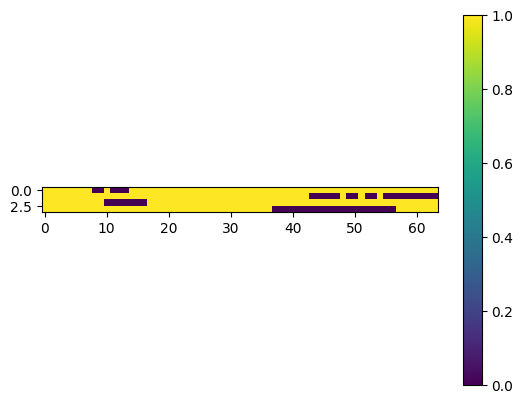

In [43]:
logits = torch.randn(4, 64, 100)
logits.requires_grad = True

loss = nn.functional.cross_entropy(
    logits.view(-1, logits.size(-1)), tgt.view(-1), ignore_index=tokenizer.pad_token_id
)
print(loss)

loss.backward()

# check that pad tokens have no gradient
grads = logits.grad.sum(dim=-1)
print(grads.shape)

plt.imshow(grads.detach().numpy() == 0)
plt.colorbar()
plt.show()